MIT License

Copyright (c) Microsoft Corporation. All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Helpers

This notebook uses [Wolfram Language kernel for Jupyter notebooks](https://github.com/WolframResearch/WolframLanguageForJupyter)

In [4]:
WithTime[res_] := 
  Column[{"Calculaton time: " <> ToString[#[[1]]] <> " seconds.", #[[
       2]]}] &@Timing [res];
SetAttributes[WithTime, HoldAll];
FramedGrid[x_] := Grid[x, Frame -> All];

## Code for computing dyadic monotone $\mu_2$ and nullity $\nu$ [[arXiv:1904.01124]](https://arxiv.org/pdf/1904.01124.pdf)

In [7]:
(* 1-2. Pauli matrices from integers *)
{Id, X, Y, Z} = Table[ PauliMatrix[k], {k, 0, 3}];
PauliFromBits[{0, 0}] = SparseArray[Id];
PauliFromBits[{0, 1}] = SparseArray[Z];
PauliFromBits[{1, 0}] = SparseArray[X];
PauliFromBits[{1, 1}] = SparseArray[Y];
PauliFromInteger[ a_Integer, 1 ] := 
  PauliFromBits@ IntegerDigits[a, 2, 2];
PauliFromInteger[ a_Integer, totalQubits_Integer ] := 
 KroneckerProduct @@ (PauliFromBits /@ Partition[#, 2] & @ 
    IntegerDigits[a, 2, 2 totalQubits])

(* 3. Expectation ⟨ψ|A|ψ⟩ where |ψ⟩ is vector and A is observable. *)
ObservableExpectation [vector_, observable_] := (observable.vector).Conjugate[vector];
VectorNorm[vector_] := vector.Conjugate[vector]

(* 4. version of IntegerExpeonent function that fails if a is not power of base *)
EnsureProperty[value_, predicate_, message_] := 
  If [predicate[value], value, Throw[message]];
StrictIntegerExponent[ a_Integer, base_Integer ] := 
  EnsureProperty[IntegerExponent[a, base], base^# == a &, 
   "StrictIntegerExponent: Argument is not a power of the base"] ;

(* 5. Returns the number of qubits described by a vector; fails if dimension of vector is not 2ⁿ *)
Qubits[vector_] := StrictIntegerExponent[Length[vector], 2];

(* 6. Pauli Spectrum, Page 8 in [arXiv:1904.01124] *)
PauliSpectrum[ vector_] := 
  PauliSpectrum[vector] = 
   Union@ParallelTable[ 
     Abs@ObservableExpectation[vector, 
       PauliFromInteger[k, Qubits[vector]] ], {k, 0, 
      4^Qubits[vector] - 1}];

(* 7-8. Version of IntegerExponent function extended to rational numbers *)
IntegerExponentForRationals[ a_Rational, base_Integer] :=  
  IntegerExponent[Numerator[a], base] - 
   IntegerExponent[Denominator[a], base];
IntegerExponentForRationals[ a_Integer, base_Integer] :=  
  IntegerExponent[a, base];

(* 9-10. Computes normalized 2-adic valuation ν₂ for integers and rationals, Page 26 in [arXiv:1904.01124] *)
v2[number_Rational] := 
  If[number == 0, \!\(TraditionalForm\`\[Infinity]\), 
   IntegerExponentForRationals [ number, 2 ]  ];
v2[number_Integer] := 
  If[number == 0, \!\(TraditionalForm\`\[Infinity]\), 
   IntegerExponent[number, 2] ];

(* 11. Degree of minimal polynomial that defines an algebraic number *)
AlgebraicNumberPolynomialDegree[ number_AlgebraicNumber] := 
  Exponent[MinimalPolynomial[number, y], y] ;

(* 12. Normalized 2-adic valuation v₂ for algebraic numbers, equivalent to Eq.(38) on Page 49 in [arXiv:1904.01124] *)
v2[ number_AlgebraicNumber ] := 
  v2[number] = 
   IntegerExponentForRationals[AlgebraicNumberNorm[number], 2] / 
    AlgebraicNumberPolynomialDegree[number];

(* 13. Dyadic monotone μ₂, Page 26 in [arXiv:1904.01124] *)
(* adding v₂ of the vector norm squared to allow for unnormalized states *)
EnsureNumeric[value_] := 
  EnsureProperty[value, NumericQ, 
   "EnsureNumeric: Argument must be a numeric value"];
mu2[vector_] := 
  Max@ ParallelMap[-v2[ToNumberField[#]] &, 
     PauliSpectrum[EnsureNumeric /@ vector] ] + v2@VectorNorm[vector];

(* 14. Nullity ν, Page 7 in [arXiv:1904.01124] *)
nu[vector_] := 
 Qubits[EnsureNumeric /@ vector] - StrictIntegerExponent[#, 2] &@
  ParallelSum[ 
   Boole[ 
    Abs@ObservableExpectation[vector, 
       PauliFromInteger[k, Qubits[vector]] ] == VectorNorm[vector] ],
   {k, 0, 4^Qubits[vector] - 1} ]

## Some states we compute μ₂ and ν of

In [41]:
FourierState[n_Integer, j_Integer] := 
  Table[ Exp[ 2 I Pi k j /2 ^n] , { k, 0, 2^n - 1}];
QuantumFourierTransform[n_Integer ] := 
  Table[FourierState[n, k], {k, 0, 2^n - 1}];
HammingWeightOneState[n_] := 
  SparseArray[#[[2, 1]], {2^n }] &@ 
   Reap@Table[ 
     If[Total@ IntegerDigits[k, 2] == 1 , Sow[k + 1 -> 1], 0], {k, 0, 
      2^ n - 1}];
(* |Cⁿ⁻¹Z^(2^-d)⟩ where n is the number of qubits *)
CRootOfZState[d_Integer, qubits_Integer] := 
  Table[ If[ k == 2^qubits, Exp[ I Pi /2 ^d ], 1] , {k, 2^qubits}];
(* T gate *)
T = MatrixExp[ I Pi (Id - Z)/8];
(* Tensor power of a given matrix on totalQubits qubits *)
TensorPower[matrix_List, totalQubits_Integer] := 
  KroneckerProduct @@ Table[ matrix, {k, 1, totalQubits}];
(* W states as defined on Page 12 of [arXiv:1904.01124] *)
WState[n_] := 
  Diagonal[ 
   TensorPower[T, n].MatrixExp[ 
     I Pi (TensorPower[Id, n] - TensorPower[Z, n])/8]];
(* Multiply controlled Z state on totalQubits qubits with controlled Z gate acting on subset of qubits given by targets *) 
MultiCZState[targets_List, totalQubits_Integer] := 
  Table[  (-1)^
    Fold[Times, IntegerDigits[ k, 2, totalQubits] [[targets]]] , {k, 
    0, 2^totalQubits - 1}];
(* Modular adder matrix *)
ModularAddBits[ a_List , b_List ] := 
  a ~Join~IntegerDigits[#, 2, Length[a]] &@ 
   Mod[ FromDigits[a] + FromDigits[b], 2^Length[a]] ; 
ModularAdder[ numQubits_Integer ] := Table[
    {k , 1 + FromDigits[#, 2] &@ 
         ModularAddBits[#[[1 ;; numQubits ]], #[[ 
           numQubits + 1 ;; 2 numQubits]] ] & @   
       IntegerDigits[k - 1, 2, 2 numQubits]} -> 1,
     {k, 1, 2^(2 numQubits)} ] // SparseArray;

## Values of μ₂ and ν that can be computed reasonably fast 
Performance is reasonably good for the states on up to 7 qubits, 8-10 qubits are still doable 

### Multiply-controlled dyadic roots of Z states

Out[58]:
 
 
 
 
 Out[59]:
 
 
 
 
 Out[60]:
 
 
 
 
 Out[61]:
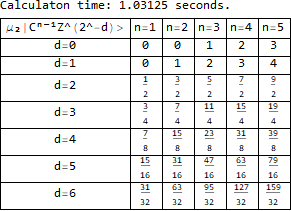
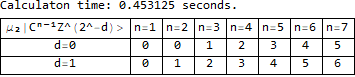

In [57]:
CRootOfZTable[ dMax_, qubitMax_  , monotone_, name_ ] := 
 {{name <> 
      "|Cⁿ⁻¹Z^(2^-d)>"} ~Join~
    Table["n=" <> ToString[q], {q, 1, qubitMax}]}~Join~
  Table[ {"d=" <> ToString[d]}~Join~ 
    Table[ monotone[CRootOfZState[d, q] ], {q, 1, qubitMax } ] , {d, 
    0, dMax}]
CRootOfZTable[6, 5, mu2 , "μ₂"] //
   FramedGrid // WithTime
CRootOfZTable[1, 7, mu2 , "μ₂"] //
   FramedGrid // WithTime
CRootOfZTable[6, 5, nu, "ν"] // FramedGrid // WithTime
CRootOfZTable[1, 6, nu , "ν"] // FramedGrid // WithTime

### Hamming weight 1 states


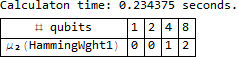

In [62]:
HammingWeightOneStateTableMu[  qubitPowerMax_Integer ] := 
 {{"# qubits", 
     "μ₂(HammingWght1)"}}~Join~
   Table[
    {2^q, mu2[HammingWeightOneState[2^q] ]}, {q, 0, qubitPowerMax}
    ] // Transpose
HammingWeightOneStateTableMu[3] // FramedGrid // WithTime


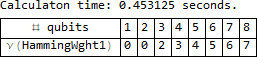

In [64]:
HammingWeightOneStateTableNu[  qubitMax_Integer ] := 
 {{"# qubits", "ν(HammingWght1)"}}~Join~
   Table[
    {q, nu[HammingWeightOneState[q] ]}, {q, 1, qubitMax}
    ] // Transpose
HammingWeightOneStateTableNu[8] // FramedGrid // WithTime

### QFT Choi states


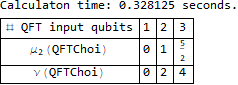

In [66]:
QFTChoiStateTable[  qubitMax_Integer ] := 
 {{"# QFT input qubits", 
     "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(QFTChoi)", 
     "\[Nu](QFTChoi)"} }~Join~
   Table[
    {q, mu2[Flatten@QuantumFourierTransform[q] ], 
     nu[Flatten@QuantumFourierTransform[q]]}, {q, 1, qubitMax}
    ] // Transpose 
QFTChoiStateTable[3] // FramedGrid // WithTime

### Wₙ states ( see [Page 12](https://arxiv.org/pdf/1904.01124.pdf#page=12) of  [[arXiv:1904.01124]](https://arxiv.org/pdf/1904.01124.pdf) )


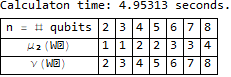

In [68]:
WStateTable[  qubitMax_Integer ] := 
 {{"n = # qubits", 
     "μ₂(Wₙ)", 
     "ν(Wₙ)"} }~Join~
   Table[
    {q, mu2[WState[q] ], nu[WState[q]]}, {q, 2, qubitMax}
    ] // Transpose 
WStateTable[8] // FramedGrid // WithTime

### CCZ₁₂₃CCZ₁₄₅

In [70]:
MultiCZState[{1, 2, 3}, 5] MultiCZState[{1, 4, 5}, 5] // 
  mu2 // WithTime

In [71]:
MultiCZState[{1, 2, 3}, 5] MultiCZState[{1, 4, 5}, 5] // 
  nu // WithTime

### States showing that μ₂ can increase after two post-selected measurements 
Counter-example state is a four qubit state.

In [72]:
Psi = {1, -I, -5 I - 2, -I, -2 I + 1, -I - 2, -I, -I + 2, 1, I, I + 2,
    I, 1, I, I + 2, I};
{ 
   {"\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)|\[CapitalPsi]\[RightAngleBracket]", 
    "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(\!\(\*SubscriptBox[\(P\), \(00\)]\)|\[CapitalPsi]\[RightAngleBracket])", 
    "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(\!\(\*SubscriptBox[\(P\), \(01\)]\)|\[CapitalPsi]\[RightAngleBracket])", 
    "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(\!\(\*SubscriptBox[\(P\), \(10\)]\)|\[CapitalPsi]\[RightAngleBracket])", 
    "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(\!\(\*SubscriptBox[\(P\), \(11\)]\)|\[CapitalPsi]\[RightAngleBracket])"},
   { mu2@Psi, mu2@ Psi[[1 ;; 4]], mu2@ Psi[[5 ;; 8]], 
    mu2@ Psi[[9 ;; 12]], mu2@ Psi[[13 ;; 16]]}
   } // FramedGrid // WithTime

In [74]:
"Here we use notation \*SubscriptBox[P, ab ] = \[LeftBracketingBar]ab \[RightAngleBracket]\[LeftAngleBracket]ab\[RightBracketingBar]\[CircleTimes]\*SubscriptBox[\[ScriptCapitalI], 2]"

### Modular adder Choi state

In [75]:
AdderChoiStateTable[  qubitMax_Integer ] := 
 {{"# Bits", "\!\(\*SubscriptBox[\(\[Mu]\), \(2\)]\)(ModAdderChoi)", 
     "ν(ModAdderChoi)"} }~Join~
   Table[
    {q, mu2[Flatten@ModularAdder[q] ], 
     nu[Flatten@ModularAdder[q]]}, {q, 1, qubitMax}
    ] // Transpose 
AdderChoiStateTable[2] // FramedGrid // WithTime

## Some calculations of Subscript μ₂ and ν that take longer time 

### 8 qubits

In [77]:
WState[8] // mu2 // WithTime

In [78]:
QuantumFourierTransform[4] // Flatten // mu2 // WithTime

In [79]:
QuantumFourierTransform[4] // Flatten // nu // WithTime

### 9 qubits 

In [80]:
WState[9] // mu2 // WithTime

In [81]:
WState[9] // nu // WithTime

In [82]:
HammingWeightOneState[9] // nu // WithTime

### 10 qubits

In [83]:
WState[10] // mu2 // WithTime

In [84]:
QuantumFourierTransform[5] // Flatten // nu // WithTime

In [85]:
QuantumFourierTransform[5] // Flatten // mu2 // WithTime

In [ ]:
HammingWeightOneState[10] // nu // WithTime